# BirdCLEF 2021 - Birdcall Identification

# Imports

In [29]:
import os

import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import librosa
import librosa.display
import numpy as np

from sklearn.utils import shuffle
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf

import plotly.graph_objects as go
import geopandas as gpd
import seaborn as sns
from sklearn.metrics import f1_score

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs: 1


In [4]:
# Variables globales
RANDOM_SEED = 2021
SAMPLE_RATE = 32000
SIGNAL_LENGTH = 5 # seconds
SPEC_SHAPE = (48, 128) # height x width
FMIN = 500
FMAX = 12500
MAX_AUDIO_FILES = 1500

## Análisis exploratorio

In [5]:
path = '../input/birdclef-2021'
files = os.listdir(path)
csvs = [f for f in files if f.endswith(".csv")]
folders = [f for f in files if not f.endswith(".csv")]
print(csvs)
print(folders)

['train_soundscape_labels.csv', 'sample_submission.csv', 'test.csv', 'train_metadata.csv']
['test_soundscapes', 'train_soundscapes', 'train_short_audio']


In [4]:
test_data = pd.read_csv(os.path.join(path, 'test.csv'))
samp_subm = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

NameError: name 'pd' is not defined

In [6]:
train_labels = pd.read_csv(os.path.join(path, 'train_soundscape_labels.csv'))
train_labels

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall
...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall
2396,54955_SSW_585,SSW,54955,585,grycat
2397,54955_SSW_590,SSW,54955,590,grycat
2398,54955_SSW_595,SSW,54955,595,nocall


In [7]:
train_data = pd.read_csv(os.path.join(path, 'train_metadata.csv'))
train_data

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62869,yetvir,[],"['adult', 'male', 'song']",30.2150,-97.6505,Vireo flavifrons,Yellow-throated Vireo,Caleb Helsel,2020-07-10,XC591680.ogg,Creative Commons Attribution-NonCommercial-Sha...,1.0,08:30,https://www.xeno-canto.org/591680
62870,yetvir,[],"['life stage uncertain', 'sex uncertain', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2019-05-31,XC600085.ogg,Creative Commons Attribution-NonCommercial-Sha...,5.0,09:30,https://www.xeno-canto.org/600085
62871,yetvir,"['amered', 'eawpew', 'norcar', 'reevir1']","['adult', 'male', 'song']",42.3005,-72.5877,Vireo flavifrons,Yellow-throated Vireo,Christopher McPherson,2020-06-02,XC602701.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.5,08:30,https://www.xeno-canto.org/602701
62872,yetvir,[],['uncertain'],32.2357,-99.8811,Vireo flavifrons,Yellow-throated Vireo,Brad Banner,2019-04-27,XC614733.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,17:30,https://www.xeno-canto.org/614733


De este dataframe, vamos a explorar gráficamente las siguientes columnas:

- Nombre del pájaro
- Coordenadas de la grabación
- Rating de la grabación (calidad de la grabación)

In [23]:
# Unique eBird codes
species = train_data['primary_label'].value_counts()
# Make bar chart
fig = go.Figure(data=[go.Bar(y=species.values, x=species.index)],
                layout=go.Layout(margin=go.layout.Margin(l=0, r=0, b=10, t=50)))
# Show chart
fig.update_layout(title='Número de instancias por especie',
                  xaxis = go.XAxis(
                    title = 'Especies',
                    showticklabels=False)
                );
fig.show()

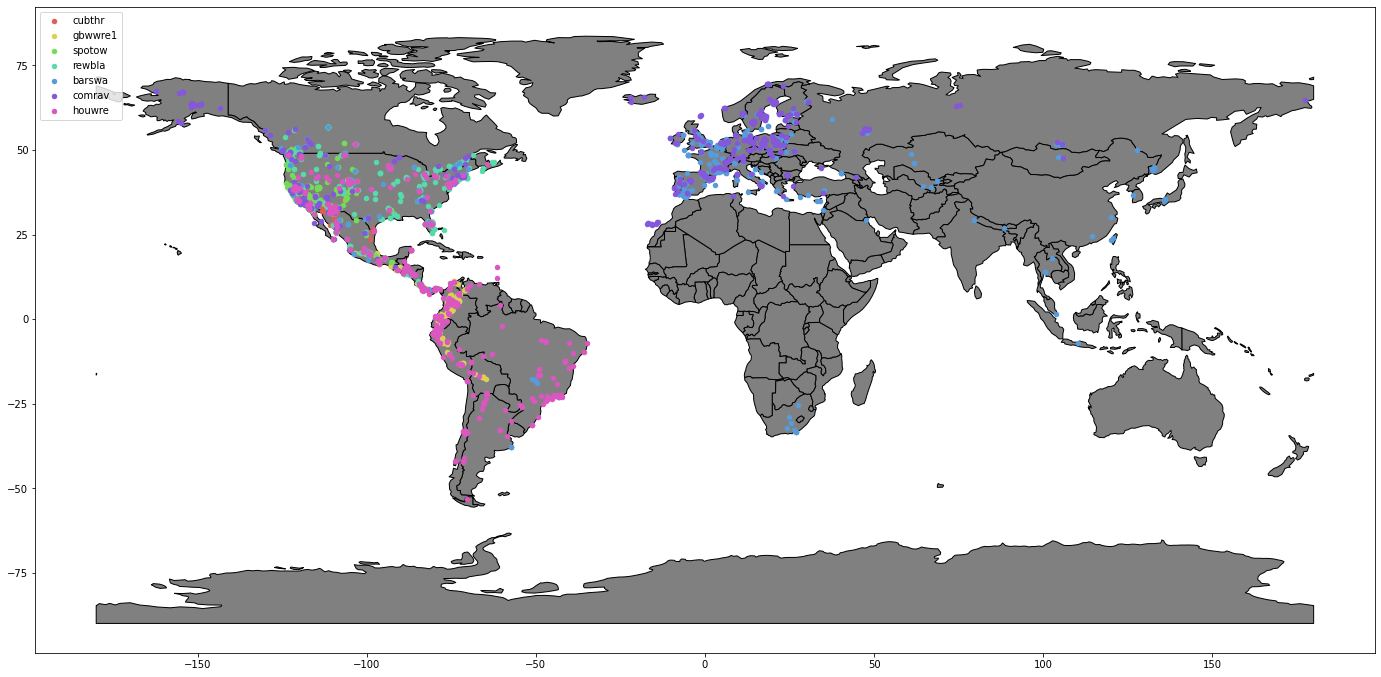

In [9]:
NUM_SPECIES_TO_PLOT = 7

species_list = species.index[:NUM_SPECIES_TO_PLOT].tolist()
data = train_data[train_data['primary_label'].isin(species_list)]

gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude,data.latitude)) 
 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig,ax = plt.subplots(figsize=(24,12))
world.plot(ax=ax, color='grey', edgecolor='black')

species_id = gdf["primary_label"].value_counts().reset_index()
species_id.insert(0, 'ID', range(0, 0 + len(species_id)))

species_id.columns = ["ID", "primary_label", "count"]

# Add ID to geo_df
gdf = pd.merge(gdf, species_id, how="left", on="primary_label")

palette = iter(sns.hls_palette(len(species_id)))
for i in range(len(species_list)):
    gdf[gdf["ID"] == i].plot(ax=ax, 
                                   markersize=20, 
                                   color=next(palette), 
                                   marker="o", 
                                   label = species_id['primary_label'].values[i]);
    
ax.legend()

In [10]:
hist_data = train_data['rating'].values.tolist()
fig = go.Figure(data=[go.Histogram(x=hist_data)], 
                layout=go.Layout(margin=go.layout.Margin(l=0, r=0, b=10, t=50)))
fig.update_layout(title='Número de registros por rating')

fig.show()

## Preprocesamiento de los datos

In [11]:
# Variables globales
RANDOM_SEED = 2021
SAMPLE_RATE = 32000
SIGNAL_LENGTH = 5 # segundos
SPEC_SHAPE = (48, 128) # alto x ancho
FMIN, FMAX = 500, 12500 # Rango de frecuencias

MIN_RATING = 3.5
MIN_RECORDS_PER_SPECIE = 100

MAX_AUDIO_FILES = 2000
MAX_AUDIO_DURATION = 15

Explicar variables globales

In [12]:
train = train_data.loc[train_data.rating >= MIN_RATING]
birds_count = {}
for bird_species, count in zip(train.primary_label.unique(), 
                               train.groupby('primary_label')['primary_label'].count().values):
    birds_count[bird_species] = count
most_represented_birds = [key for key,value in birds_count.items() if value >= MIN_RECORDS_PER_SPECIE] 

TRAIN = train.query('primary_label in @most_represented_birds')
LABELS = sorted(TRAIN.primary_label.unique())

# Let's see how many species and samples we have left
print('NUMBER OF SPECIES IN TRAIN DATA:', len(LABELS))
print('NUMBER OF SAMPLES IN TRAIN DATA:', len(TRAIN))
print('LABELS:', most_represented_birds)

NUMBER OF SPECIES IN TRAIN DATA: 200
NUMBER OF SAMPLES IN TRAIN DATA: 36362
LABELS: ['acafly', 'acowoo', 'aldfly', 'amecro', 'amegfi', 'amered', 'amerob', 'andsol1', 'astfly', 'azaspi1', 'balori', 'banana', 'barant1', 'barswa', 'bawwar', 'baywre1', 'bbwduc', 'bcnher', 'belvir', 'bewwre', 'bkbplo', 'bkcchi', 'bkhgro', 'bkmtou1', 'bknsti', 'blbgra1', 'blhpar1', 'blkpho', 'blugrb1', 'blujay', 'bncfly', 'bnhcow', 'bobfly1', 'brbsol1', 'brncre', 'brnthr', 'brratt1', 'buggna', 'bugtan', 'buhvir', 'bulori', 'burwar1', 'bushti', 'butsal1', 'cacwre', 'cangoo', 'carchi', 'carwre', 'caskin', 'caster1', 'ccbfin', 'chbant1', 'chcant2', 'chispa', 'chswar', 'cinfly2', 'clcrob', 'cobtan1', 'coltro1', 'compau', 'comrav', 'comyel', 'cubthr', 'daejun', 'dowwoo', 'ducfly', 'easmea', 'eastow', 'eawpew', 'eucdov', 'eursta', 'fepowl', 'fiespa', 'foxspa', 'gadwal', 'gbwwre1', 'gcrwar', 'gnttow', 'gnwtea', 'gockin', 'grasal1', 'grcfly', 'greegr', 'grekis', 'grethr1', 'grhowl', 'grtgra', 'grycat', 'gwfgoo', 'ha

In [13]:
# Shuffle the training data and limit the number of audio files to MAX_AUDIO_FILES
TRAIN = shuffle(TRAIN, random_state=RANDOM_SEED)[:MAX_AUDIO_FILES]

LABELS = sorted(TRAIN.primary_label.unique())

print('NUMBER OF SPECIES IN TRAIN DATA:', len(LABELS))
print('FINAL NUMBER OF AUDIO FILES IN TRAINING DATA:', len(TRAIN))
print('LABELS:', LABELS)

NUMBER OF SPECIES IN TRAIN DATA: 200
FINAL NUMBER OF AUDIO FILES IN TRAINING DATA: 2000
LABELS: ['acafly', 'acowoo', 'aldfly', 'amecro', 'amegfi', 'amered', 'amerob', 'andsol1', 'astfly', 'azaspi1', 'balori', 'banana', 'barant1', 'barswa', 'bawwar', 'baywre1', 'bbwduc', 'bcnher', 'belvir', 'bewwre', 'bkbplo', 'bkcchi', 'bkhgro', 'bkmtou1', 'bknsti', 'blbgra1', 'blhpar1', 'blkpho', 'blugrb1', 'blujay', 'bncfly', 'bnhcow', 'bobfly1', 'brbsol1', 'brncre', 'brnthr', 'brratt1', 'buggna', 'bugtan', 'buhvir', 'bulori', 'burwar1', 'bushti', 'butsal1', 'cacwre', 'cangoo', 'carchi', 'carwre', 'caskin', 'caster1', 'ccbfin', 'chbant1', 'chcant2', 'chispa', 'chswar', 'cinfly2', 'clcrob', 'cobtan1', 'coltro1', 'compau', 'comrav', 'comyel', 'cubthr', 'daejun', 'dowwoo', 'ducfly', 'easmea', 'eastow', 'eawpew', 'eucdov', 'eursta', 'fepowl', 'fiespa', 'foxspa', 'gadwal', 'gbwwre1', 'gcrwar', 'gnttow', 'gnwtea', 'gockin', 'grasal1', 'grcfly', 'greegr', 'grekis', 'grethr1', 'grhowl', 'grtgra', 'grycat', '

Tenemos 2000 audios con 200 especies represantadas.

In [14]:
# Define a function that splits an audio file, 
# extracts spectrograms and saves them in a working directory
def get_spectrograms(filepath, primary_label, output_dir):
    
    # Open the file with librosa (limited to the first 15 seconds)
    sig, rate = librosa.load(filepath, sr=SAMPLE_RATE, offset=None, duration=MAX_AUDIO_DURATION)
    
    # Split signal into five second chunks
    sig_splits = []
    for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
        split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]

        # End of signal?
        if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
            break
        
        sig_splits.append(split)
        
    # Extract mel spectrograms for each audio chunk
    s_cnt = 0
    saved_samples = []
    for chunk in sig_splits:
        
        hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
        mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                                  sr=SAMPLE_RATE, 
                                                  n_fft=1024, 
                                                  hop_length=hop_length, 
                                                  n_mels=SPEC_SHAPE[0], 
                                                  fmin=FMIN, 
                                                  fmax=FMAX)
    
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 
        
        # Normalize
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()
        
        # Save as image file
        save_dir = os.path.join(output_dir, primary_label)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, filepath.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0] + 
                                 '_' + str(s_cnt) + '.png')
        im = Image.fromarray(mel_spec * 255.0).convert("L")
        im.save(save_path)
        
        saved_samples.append(save_path)
        s_cnt += 1
        
        
    return saved_samples

In [15]:
# Parse audio files and extract training samples
input_dir = '../input/birdclef-2021/train_short_audio/'
output_dir = '../working/melspectrogram_dataset/'
samples = []
with tqdm(total=len(TRAIN)) as pbar:
    for idx, row in TRAIN.iterrows():
        pbar.update(1)
        
        if row.primary_label in most_represented_birds:
            audio_file_path = os.path.join(input_dir, row.primary_label, row.filename)
            samples += get_spectrograms(audio_file_path, row.primary_label, output_dir)
            
TRAIN_SPECS = shuffle(samples, random_state=RANDOM_SEED)
print('SUCCESSFULLY EXTRACTED {} SPECTROGRAMS'.format(len(TRAIN_SPECS)))

100%|██████████| 2000/2000 [00:40<00:00, 49.15it/s]SUCCESSFULLY EXTRACTED 5559 SPECTROGRAMS



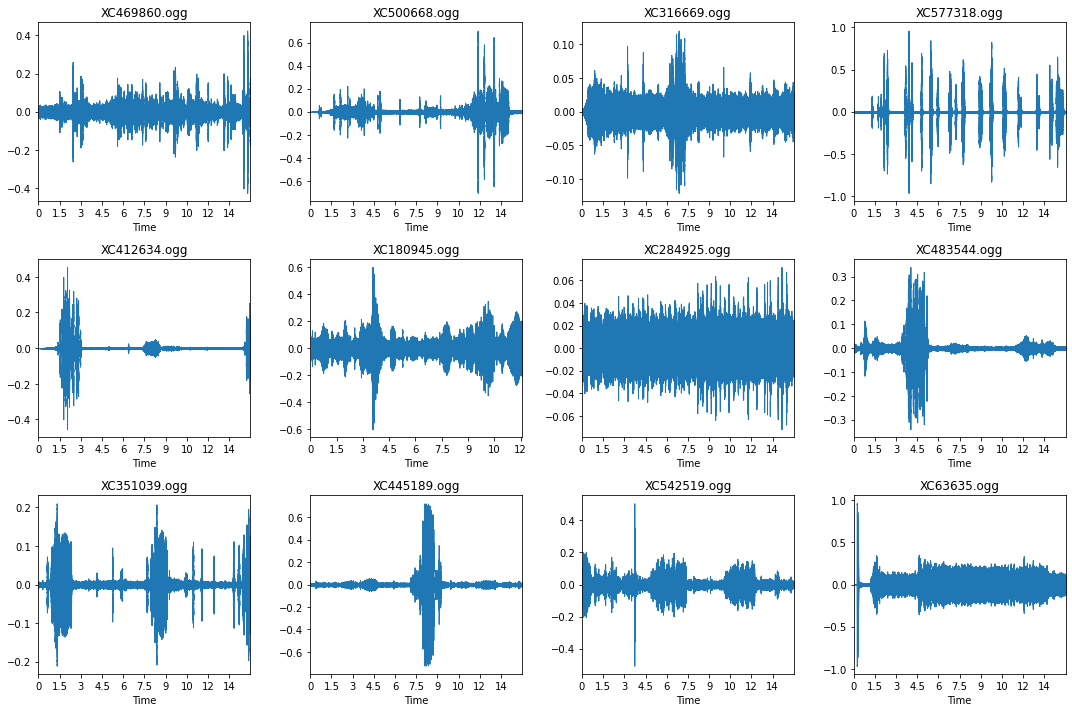

In [17]:
plt.figure(figsize=(15, 10))

for i in range(12):
    bird = TRAIN_SPECS[i].split("/")[-2]
    audio = TRAIN_SPECS[i].split("/")[-1].split(".png")[0].split("_")[0]
    path = os.path.join("../input/birdclef-2021/train_short_audio", bird, audio+".ogg")
    plt.subplot(3, 4, i + 1)
    plt.title(path.split(os.sep)[-1])
    sig, rate = librosa.load(path, sr=32000, offset=None, duration=15)
    librosa.display.waveplot(sig, sr=32000)

plt.tight_layout()

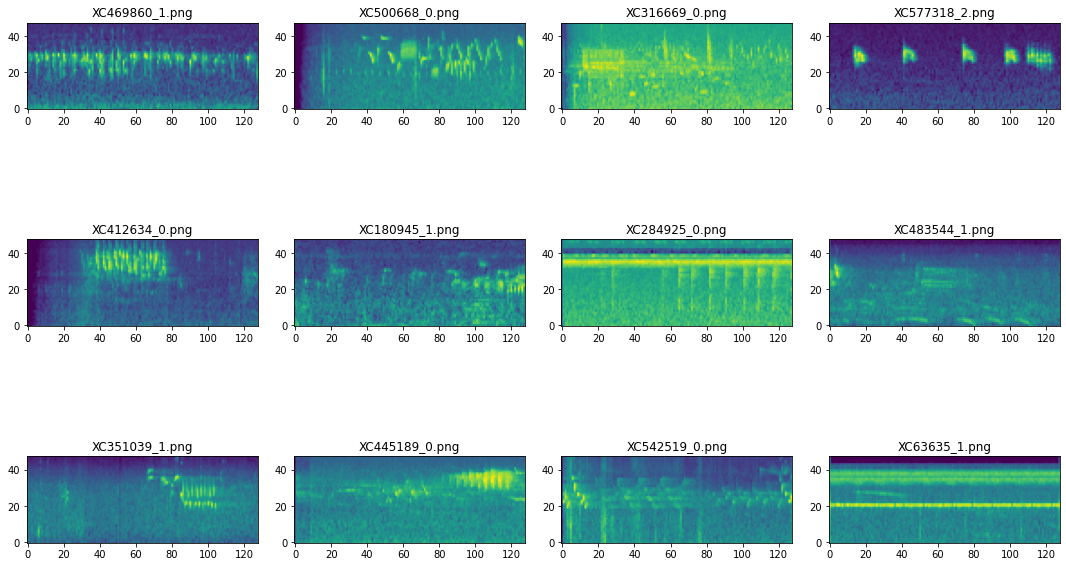

In [18]:
plt.figure(figsize=(15, 10))
for i in range(12):
    spec = Image.open(TRAIN_SPECS[i])
    plt.subplot(3, 4, i + 1)
    plt.title(TRAIN_SPECS[i].split(os.sep)[-1])
    plt.imshow(spec, origin='lower')

plt.tight_layout()

In [19]:
# Parse all samples and add spectrograms into train data, primary_labels into label data
train_specs, train_labels = [], []
with tqdm(total=len(TRAIN_SPECS)) as pbar:
    for path in TRAIN_SPECS:
        pbar.update(1)

        # Open image
        spec = Image.open(path)

        # Convert to numpy array
        spec = np.array(spec, dtype='float32')
        
        # Normalize between 0.0 and 1.0
        # and exclude samples with nan 
        spec -= spec.min()
        spec /= spec.max()
        if not spec.max() == 1.0 or not spec.min() == 0.0:
            continue

        # Add channel axis to 2D array
        spec = np.expand_dims(spec, -1)

        # Add new dimension for batch size
        spec = np.expand_dims(spec, 0)

        # Add to train data
        if len(train_specs) == 0:
            train_specs = spec
        else:
            train_specs = np.vstack((train_specs, spec))

        # Add to label data
        target = np.zeros((len(LABELS)), dtype='float32')
        bird = path.split(os.sep)[-2]# Define a function that splits an audio file, 
        
        target[LABELS.index(bird)] = 1.0
        if len(train_labels) == 0:
            train_labels = target
        else:
            train_labels = np.vstack((train_labels, target))

100%|██████████| 5559/5559 [00:56<00:00, 99.22it/s]


In [20]:
# Make sure your experiments are reproducible
tf.random.set_seed(RANDOM_SEED)

# Build a simple model as a sequence of  convolutional blocks.
# Each block has the sequence CONV --> RELU --> BNORM --> MAXPOOL.
# Finally, perform global average pooling and add 2 dense layers.
# The last layer is our classification layer and is softmax activated.
# (Well it's a multi-label task so sigmoid might actually be a better choice)
model = tf.keras.Sequential([
    
    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    #tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    #tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    #tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Fourth conv block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    #tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(), 
    #tf.keras.layers.Flatten(),

    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])
print('MODEL HAS {} PARAMETERS.'.format(model.count_params()))

MODEL HAS 248328 PARAMETERS.


In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy'])

In [22]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                  patience=5, 
                                                  verbose=1, 
                                                  factor=0.25),
             tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              verbose=1,
                                              patience=10),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', 
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True)]

In [24]:
model.fit(train_specs, 
          train_labels,
          batch_size=64,
          validation_split=0.2,
          callbacks=callbacks,
          epochs=75)

Epoch 1/75
70/70 [==============================] - 2s 16ms/step - loss: 5.4736 - accuracy: 0.0089 - val_loss: 5.2519 - val_accuracy: 0.0162

Epoch 00001: val_accuracy improved from -inf to 0.01619, saving model to best_model.h5
Epoch 2/75
70/70 [==============================] - 1s 9ms/step - loss: 5.1843 - accuracy: 0.0236 - val_loss: 5.2454 - val_accuracy: 0.0162

Epoch 00002: val_accuracy did not improve from 0.01619
Epoch 3/75
70/70 [==============================] - 1s 9ms/step - loss: 5.1027 - accuracy: 0.0299 - val_loss: 5.2514 - val_accuracy: 0.0162

Epoch 00003: val_accuracy did not improve from 0.01619
Epoch 4/75
70/70 [==============================] - 1s 9ms/step - loss: 5.0084 - accuracy: 0.0365 - val_loss: 5.2501 - val_accuracy: 0.0072

Epoch 00004: val_accuracy did not improve from 0.01619
Epoch 5/75
70/70 [==============================] - 1s 9ms/step - loss: 4.8644 - accuracy: 0.0506 - val_loss: 5.2313 - val_accuracy: 0.0108

Epoch 00005: val_accuracy did not improve 

In [25]:
# Load the best checkpoint
model = tf.keras.models.load_model('best_model.h5')

# Pick a soundscape
soundscape_path = '../input/birdclef-2021/train_soundscapes/28933_SSW_20170408.ogg'

# Open it with librosa
sig, rate = librosa.load(soundscape_path, sr=SAMPLE_RATE)

# Store results so that we can analyze them later
data = {'row_id': [], 'prediction': [], 'score': []}

# Split signal into 5-second chunks
# Just like we did before (well, this could actually be a seperate function)
sig_splits = []
for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
    split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]

    # End of signal?
    if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
        break

    sig_splits.append(split)
    
# Get the spectrograms and run inference on each of them
# This should be the exact same process as we used to
# generate training samples!
seconds, scnt = 0, 0
for chunk in sig_splits:
    
    # Keep track of the end time of each chunk
    seconds += 5
        
    # Get the spectrogram
    hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
    mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                              sr=SAMPLE_RATE, 
                                              n_fft=1024, 
                                              hop_length=hop_length, 
                                              n_mels=SPEC_SHAPE[0], 
                                              fmin=FMIN, 
                                              fmax=FMAX)

    mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 

    # Normalize to match the value range we used during training.
    # That's something you should always double check!
    mel_spec -= mel_spec.min()
    mel_spec /= mel_spec.max()
    
    # Add channel axis to 2D array
    mel_spec = np.expand_dims(mel_spec, -1)

    # Add new dimension for batch size
    mel_spec = np.expand_dims(mel_spec, 0)
    
    # Predict
    p = model.predict(mel_spec)[0]
    
    # Get highest scoring species
    idx = p.argmax()
    species = LABELS[idx]
    score = p[idx]
    
    # Prepare submission entry
    data['row_id'].append(soundscape_path.split(os.sep)[-1].rsplit('_', 1)[0] + 
                          '_' + str(seconds))    
    
    # Decide if it's a "nocall" or a species by applying a threshold
    if score > 0.25:
        data['prediction'].append(species)
        scnt += 1
    else:
        data['prediction'].append('nocall')
        
    # Add the confidence score as well
    data['score'].append(score)
        
print('SOUNSCAPE ANALYSIS DONE. FOUND {} BIRDS.'.format(scnt))

SOUNSCAPE ANALYSIS DONE. FOUND 61 BIRDS.


In [33]:
# Make a new data frame
results = pd.DataFrame(data, columns = ['row_id', 'prediction', 'score'])

# Merge with ground truth so we can inspect
gt = pd.read_csv('../input/birdclef-2021/train_soundscape_labels.csv',)
results = pd.merge(gt, results, on='row_id')

# Let's look at the first 50 entries
results.head(50)

,row_id,site,audio_id,seconds,birds,prediction,score
0,28933_SSW_5,SSW,28933,5,sonspa,nocall,0.130431
1,28933_SSW_10,SSW,28933,10,rewbla,nocall,0.239213
2,28933_SSW_15,SSW,28933,15,sonspa,nocall,0.234108
3,28933_SSW_20,SSW,28933,20,sonspa,nocall,0.224611
4,28933_SSW_25,SSW,28933,25,sonspa,nocall,0.090950
...,...,...,...,...,...,...,...
115,28933_SSW_580,SSW,28933,580,rewbla,savspa,0.769323
116,28933_SSW_585,SSW,28933,585,nocall,savspa,0.691161
117,28933_SSW_590,SSW,28933,590,nocall,nocall,0.242353
118,28933_SSW_595,SSW,28933,595,nocall,savspa,0.478444


In [32]:
from sklearn.metrics import f1_score
f1_score(results["birds"], results["prediction"], average=None).sum()

0.6194805194805194

In [ ]:
y_pred = model.predict_generator(test_generator, verbose=1)

In [ ]:
y_test = np.where(y_pred > 0.5, 1, 0)

In [ ]:
for row in samp_subm.index:
    string = ''
    for col in range(len(y_test[row])):
        if y_test[row][col] == 1:
            if string == '':
                string += labels[col]
            else:
                string += ' ' + labels[col]
    if string == '':
        string = 'nocall'
    samp_subm.loc[row, 'birds'] = string

In [ ]:
output = samp_subm
output.to_csv('submission.csv', index=False)

In [ ]:
output